While editing this notebook, don't change cell types as that confuses the autograder.

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [5]:
NAME = "Sungjoon Park"

_Understanding Deep Learning_

---

<a href="https://colab.research.google.com/github/DL4DS/sp2024_notebooks/blob/main/release/nbs08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 8.1: MNIST_1D_Performance

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a.
It uses code from https://github.com/greydanus/mnist1d to generate the data.

Adapted from notebooks at https://github.com/udlbook/udlbook.

In [6]:
# Clone the mnist1d repository if it doesn't exist
import os

if not os.path.exists('mnist1d'):
    !git clone https://github.com/greydanus/mnist1d

In [7]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
from torchinfo import summary

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [8]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [9]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
# model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o))

# YOUR CODE HERE
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o)
)
# raise NotImplementedError()

def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
#   print("Initializing layer")

    # YOUR CODE HERE
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)
model.apply(weights_init)
#   raise NotImplementedError()

# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
print(summary(model, input_size=(1, D_i), device='cpu'))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Linear: 1-1                            [1, 100]                  4,100
├─ReLU: 1-2                              [1, 100]                  --
├─Linear: 1-3                            [1, 100]                  10,100
├─ReLU: 1-4                              [1, 100]                  --
├─Linear: 1-5                            [1, 10]                   1,010
Total params: 15,210
Trainable params: 15,210
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06


In [11]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()

# construct SGD optimizer and initialize learning rate and momentum
# original lr = 0.05, momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

# object that decreases learning rate by half every 10 epochs
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# create 100 dummy data points and store in data loader class
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100 # was 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  # scheduler.step()

Epoch     0, train loss 1.816828, train error 70.88,  test loss 1.886057, test error 73.30
Epoch     1, train loss 1.676263, train error 66.90,  test loss 1.760810, test error 69.00
Epoch     2, train loss 1.541954, train error 59.65,  test loss 1.668718, test error 65.70
Epoch     3, train loss 1.518341, train error 59.53,  test loss 1.641170, test error 65.20
Epoch     4, train loss 1.413974, train error 54.33,  test loss 1.565733, test error 62.40
Epoch     5, train loss 1.350698, train error 50.72,  test loss 1.528471, test error 61.90
Epoch     6, train loss 1.274155, train error 45.92,  test loss 1.465488, test error 58.40
Epoch     7, train loss 1.249527, train error 45.40,  test loss 1.454230, test error 57.90
Epoch     8, train loss 1.173217, train error 41.60,  test loss 1.399081, test error 54.70
Epoch     9, train loss 1.151915, train error 42.60,  test loss 1.392397, test error 54.80
Epoch    10, train loss 1.115356, train error 39.65,  test loss 1.360266, test error 52.30

In [12]:
# Your trained model should satisfy these limits
# Do not modify this cell

assert losses_train[-1] < 0.05, "Loss on training set is too high"
assert errors_train[-1] < .01, "Error on training set is too high"

assert losses_test[-1] < 1.7, "Loss on test set is too high"
assert np.min(losses_test) < 1.3, "Minimum loss on test set is too high"

assert errors_test[-1] < 40, "Error on test set is too high"

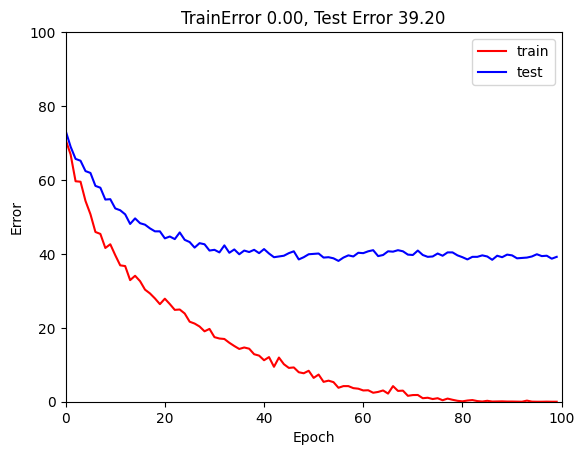

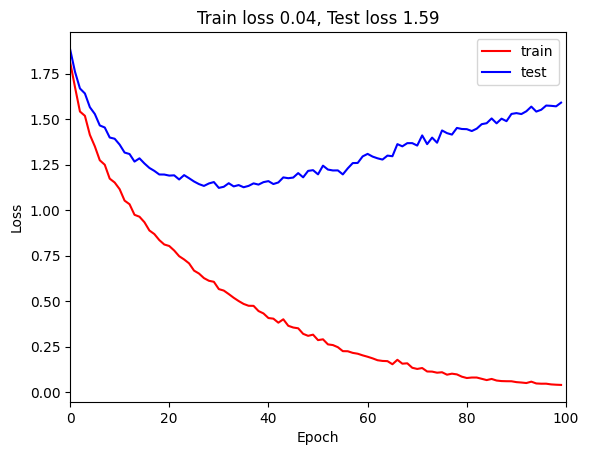

In [13]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

Look at the difference between training and test, and observe what is happening to test loss as training proceeds.

We'll also come back and compare this to the convolutional neural network later.